In [35]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from matplotlib import cm

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.size"] = "12"

In [36]:
vizwiz_train = pd.read_csv('../../data/three_vote_threshold/vizwiz_skill_typ_train.csv', skipinitialspace=True, engine='python')
vizwiz_val = pd.read_csv('../../data/three_vote_threshold/vizwiz_skill_typ_val.csv', skipinitialspace=True, engine='python')
vizwiz_test = pd.read_csv('../../data/three_vote_threshold/vizwiz_skill_typ_test.csv', skipinitialspace=True, engine='python')

vqa_train = pd.read_csv('../../data/three_vote_threshold/vqa_skill_typ_train.csv', skipinitialspace=True, engine='python')
vqa_val = pd.read_csv('../../data/three_vote_threshold/vqa_skill_typ_val.csv', skipinitialspace=True, engine='python')
vqa_test = pd.read_csv('../../data/three_vote_threshold/vqa_skill_typ_test.csv', skipinitialspace=True, engine='python')

vqa_train['QID'] = vqa_train['QID'].astype(str)
vqa_val['QID'] = vqa_val['QID'].astype(str)
vqa_test['QID'] = vqa_test['QID'].astype(str)

vizwiz = pd.concat([vizwiz_train, vizwiz_val, vizwiz_test])
vqa = pd.concat([vqa_train, vqa_val, vqa_test])
df = pd.concat([vizwiz, vqa])

# vizwiz = vizwiz[['TXT', 'OBJ', 'COL', 'CNT', 'OTH']]
# vqa = vqa[['TXT', 'OBJ', 'COL', 'CNT', 'OTH']]

# all crowdsourced data
# df = pd.read_csv('../../data/VizWiz_VQA_Skills_Data.csv', engine='python')

In [3]:
vqa.head(1)

,Unnamed: 0,QID,TXT,OBJ,COL,CNT,OTH,SRC_DATASET,ANS_TYP,IMG,...,ANS4,ANS5,ANS6,ANS7,ANS8,ANS9,ANS10,NUM_UNIQUE_ANS,NUM_MOST_COMMON_ANS,split
0,0,100063007,0,5,2,0,2,VQA,yes/no,COCO_train2014_000000100063.jpg,...,no,yes,yes,no,no,no,yes,2,6,train


In [3]:
df.columns

Index(['Unnamed: 0', 'QID', 'TXT', 'OBJ', 'COL', 'CNT', 'OTH', 'SRC_DATASET',
       'ANS_TYP', 'IMG', 'QSN', 'ANS1', 'ANS2', 'ANS3', 'ANS4', 'ANS5', 'ANS6',
       'ANS7', 'ANS8', 'ANS9', 'ANS10', 'NUM_UNIQUE_ANS',
       'NUM_MOST_COMMON_ANS', 'split'],
      dtype='object')

In [4]:
len(df)  # 3 rows not in previous train/test/splits are ignored

27260

In [5]:
df['QID'].nunique()

27260

In [6]:
df['SRC_DATASET'].unique()

array(['VizWiz', 'VQA'], dtype=object)

#### figure 2, dist of skill combinations

In [204]:
# none of the above - no agreed skill label
dset = vqa
(len(dset.loc[(dset['OBJ'] < 3) 
           & (dset['COL'] < 3) 
           & (dset['TXT'] < 3)
           & (dset['CNT'] < 3)
           & (dset['OTH'] < 3)]) / len(dset) ) # * 100

0.00834326579261025

In [6]:
# percentage of QA with a single skill
dset = vizwiz

obj = (dset.loc[(dset['OBJ'] >= 3) 
           & (dset['COL'] < 3) 
           & (dset['TXT'] < 3)
           & (dset['CNT'] < 3)
           & (dset['OTH'] < 3)])
col = (dset.loc[(dset['OBJ'] < 3) 
           & (dset['COL'] >= 3) 
           & (dset['TXT'] < 3)
           & (dset['CNT'] < 3)
           & (dset['OTH'] < 3)])
txt = (dset.loc[(dset['OBJ'] >= 3) 
           & (dset['COL'] < 3) 
           & (dset['TXT'] >= 3)
           & (dset['CNT'] < 3)
           & (dset['OTH'] < 3)])
cnt = (dset.loc[(dset['OBJ'] >= 3) 
           & (dset['COL'] < 3) 
           & (dset['TXT'] < 3)
           & (dset['CNT'] >= 3)
           & (dset['OTH'] < 3)])
oth = (dset.loc[(dset['OBJ'] >= 3) 
           & (dset['COL'] < 3) 
           & (dset['TXT'] < 3)
           & (dset['CNT'] < 3)
           & (dset['OTH'] >= 3)])

(len(obj) + len(col) + len(txt) + len(cnt) + len(oth)) / len(dset)

0.7619454692702241

In [224]:
len(col)

632

In [225]:
len(one_skill(vizwiz, 'COL', ratio=False))

632

In [4]:
# convert skills labels into binary based on 3-vote threshold
def convert_binary_labels(df):
    df['col'] = ""
    df['txt'] = ""
    df['cnt'] = ""
    for i, row in df.iterrows():
        if row['COL'] >= 3:
            row[-3] = 1
        if row['TXT'] >= 3:
            row[-2] = 1
        if row['CNT'] >= 3:
            row[-1] = 1
    return df

In [5]:
vizwiz = convert_binary_labels(df)
vqa = convert_binary_labels(vqa)

In [3]:
def one_skill(dset, s, ratio=True):
    skills = ['OBJ', 'COL', 'TXT', 'CNT', 'OTH']
    mute = list(set(skills) - set([s]))
    df = (dset.loc[(dset[s] >= 3) 
                   & (dset[mute[0]] < 3) 
                   & (dset[mute[1]] < 3)
                   & (dset[mute[2]] < 3) 
                   & (dset[mute[3]] < 3)])
    if ratio:
        r = len(df)/len(dset)
        print(f'{s}: {r}')
        return r
    else: return df
    
def one_skill_nonexclusive(dset, s, ratio=True):
    skills = ['OBJ', 'COL', 'TXT', 'CNT', 'OTH']
    df = dset.loc[(dset[s] >= 3)]
    if ratio:
        r = len(df)/len(dset)
        print(f'{s}: {r}')
        return r
    else: return df

    
def two_skills(dset, s1, s2, ratio=True):
    skills = ['OBJ', 'COL', 'TXT', 'CNT', 'OTH']
    mute = list(set(skills) - set([s1,s2]))
    df = (dset.loc[(dset[s1] >= 3) & (dset[s2] >= 3) 
                   & (dset[mute[0]] < 3) 
                   & (dset[mute[1]] < 3) 
                   & (dset[mute[2]] < 3)])
    if ratio:
        r = len(df)/len(dset)
        print(f'{s1} & {s2}: {r}')
        return r
    else: return df
    
def two_skill_nonexclusive(dset, s1, s2, ratio=True):
    skills = ['OBJ', 'COL', 'TXT', 'CNT', 'OTH']
    df = dset.loc[(dset[s1] >= 3) & (dset[s2] >= 3)]
    if ratio:
        r = len(df)/len(dset)
        print(f'{s1} & {s2}: {r}')
        return r
    else: return df

def three_skills(dset, s1, s2, s3, ratio=True):
    skills = ['OBJ', 'COL', 'TXT', 'CNT', 'OTH']
    mute = list(set(skills) - set([s1,s2,s3]))
    df = (dset.loc[(dset[s1] >= 3) & (dset[s2] >= 3) & (dset[s3] >= 3)
                   & (dset[mute[0]] < 3)
                   & (dset[mute[1]] < 3)])
    if ratio:
        r = len(df)/len(dset)
        print(f'{s1} & {s2} & {s3}: {r}')
        return r
    else: return df

def four_skills(dset, s1, s2, s3, s4, ratio=True):
    skills = ['OBJ', 'COL', 'TXT', 'CNT', 'OTH']
    mute = list(set(skills) - set([s1,s2,s3,s4]))
    df = (dset.loc[(dset[s1] >= 3) & (dset[s2] >= 3) & (dset[s3] >= 3) & (dset[s4] >= 3)
                   & (dset[mute[0]] < 3)])
    if ratio:
        r = len(df)/len(dset)
        print(f'{s1} & {s2} & {s3} & {s4}: {r}')
        return r
    else: return df

In [229]:
# ratio of 1 skill only
dset = vqa
(len(one_skill(dset, 'OBJ', False)) + 
len(one_skill(dset, 'COL', False)) + 
len(one_skill(dset, 'TXT', False)) + 
len(one_skill(dset, 'CNT', False)) + 
len(one_skill(dset, 'OTH', False)) ) / len(dset)

0.6313071116408423

In [230]:
# single skill dist
dset = vqa
for s in skills: 
    one_skill(dset, s)

OBJ: 0.619388160508542
COL: 0.004370282081843465
TXT: 0.002582439411998411
CNT: 0.004966229638458482
OTH: 0.0


In [231]:
dset = vqa

# two skills (5 choose 2) ratios
two_skills(dset, 'OBJ', 'COL')
two_skills(dset, 'OBJ', 'TXT')
two_skills(dset, 'OBJ', 'CNT')
two_skills(dset, 'OBJ', 'OTH')
two_skills(dset, 'COL', 'TXT')
two_skills(dset, 'COL', 'CNT')
two_skills(dset, 'COL', 'OTH')
two_skills(dset, 'TXT', 'CNT')
two_skills(dset, 'TXT', 'OTH')
two_skills(dset, 'CNT', 'OTH')

OBJ & COL: 0.15196662693682955
OBJ & TXT: 0.04529201430274136
OBJ & CNT: 0.14382201032975764
OBJ & OTH: 0.0009932459276916965
COL & TXT: 0.0
COL & CNT: 0.0001986491855383393
COL & OTH: 0.0
TXT & CNT: 0.0003972983710766786
TXT & OTH: 0.0
CNT & OTH: 0.0


0.0

In [35]:
# ratio of 2 skills
dset = vizwiz
(
len(two_skills(dset, 'OBJ', 'COL', False)) + 
len(two_skills(dset, 'OBJ', 'TXT', False)) + 
len(two_skills(dset, 'OBJ', 'CNT', False)) + 
len(two_skills(dset, 'OBJ', 'OTH', False)) + 
len(two_skills(dset, 'COL', 'TXT', False)) + 
len(two_skills(dset, 'COL', 'CNT', False)) + 
len(two_skills(dset, 'COL', 'OTH', False)) + 
len(two_skills(dset, 'TXT', 'CNT', False)) + 
len(two_skills(dset, 'TXT', 'OTH', False)) +
len(two_skills(dset, 'CNT', 'OTH', False)) ) / len(dset)

0.5934041212993791

In [45]:
# ratio of 3 skills
dset = vqa
( 
len(three_skills(dset, 'OBJ', 'COL', 'TXT', False)) + 
len(three_skills(dset, 'OBJ', 'COL', 'CNT', False)) + 
len(three_skills(dset, 'OBJ', 'COL', 'OTH', False)) + 
len(three_skills(dset, 'OBJ', 'TXT', 'CNT', False)) + 
len(three_skills(dset, 'OBJ', 'TXT', 'OTH', False)) + 
len(three_skills(dset, 'OBJ', 'CNT', 'OTH', False)) + 
len(three_skills(dset, 'OBJ', 'CNT', 'TXT', False)) + 
len(three_skills(dset, 'COL', 'TXT', 'CNT', False)) + 
len(three_skills(dset, 'COL', 'TXT', 'OTH', False)) + 
len(three_skills(dset, 'TXT', 'CNT', 'OTH', False)) ) / len(dset)

0.025029797377830752

In [57]:
# three skill combinations
dset = vqa

three_skills(dset, 'OBJ', 'TXT', 'OTH')
three_skills(dset, 'OBJ', 'COL', 'TXT')
three_skills(dset, 'OBJ', 'TXT', 'CNT')
three_skills(dset, 'OBJ', 'CNT', 'OTH')
three_skills(dset, 'OBJ', 'COL', 'OTH')
three_skills(dset, 'COL', 'TXT', 'CNT')
three_skills(dset, 'COL', 'CNT', 'OTH')
three_skills(dset, 'TXT', 'CNT', 'OTH')
three_skills(dset, 'COL', 'CNT', 'OTH')
three_skills(dset, 'COL', 'TXT', 'OTH')

OBJ & TXT & OTH: 0.0
OBJ & COL & TXT: 0.0013905442987683751
OBJ & TXT & CNT: 0.007350019864918554
OBJ & CNT & OTH: 0.0
OBJ & COL & OTH: 0.0
COL & TXT & CNT: 0.0
COL & CNT & OTH: 0.0
TXT & CNT & OTH: 0.0
COL & CNT & OTH: 0.0
COL & TXT & OTH: 0.0


0.0

In [47]:
# ratio of four skills - 5 choose 4 = 5
dset = vizwiz
skills = ['OBJ', 'COL', 'TXT', 'CNT', 'OTH']
(
len(four_skills(dset, 'OBJ', 'COL', 'TXT', 'CNT', False)) + 
len(four_skills(dset, 'OBJ', 'TXT', 'CNT', 'OTH', False)) +
len(four_skills(dset, 'OBJ', 'COL', 'CNT', 'OTH', False)) +
len(four_skills(dset, 'COL', 'TXT', 'CNT', 'OTH', False)) + 
len(four_skills(dset, 'OBJ', 'COL', 'TXT', 'OTH', False))
) / len(dset)

8.99847026005579e-05

OBJ: 0.9325114730495816
COL: 0.22064249077656797
TXT: 0.45329793935031043
CNT: 0.014892468280392333
OTH: 8.99847026005579e-05
OBJ: 0.9791418355184743
COL: 0.16686531585220502
TXT: 0.05701231624950338
CNT: 0.16567342073897498
OTH: 0.0009932459276916965


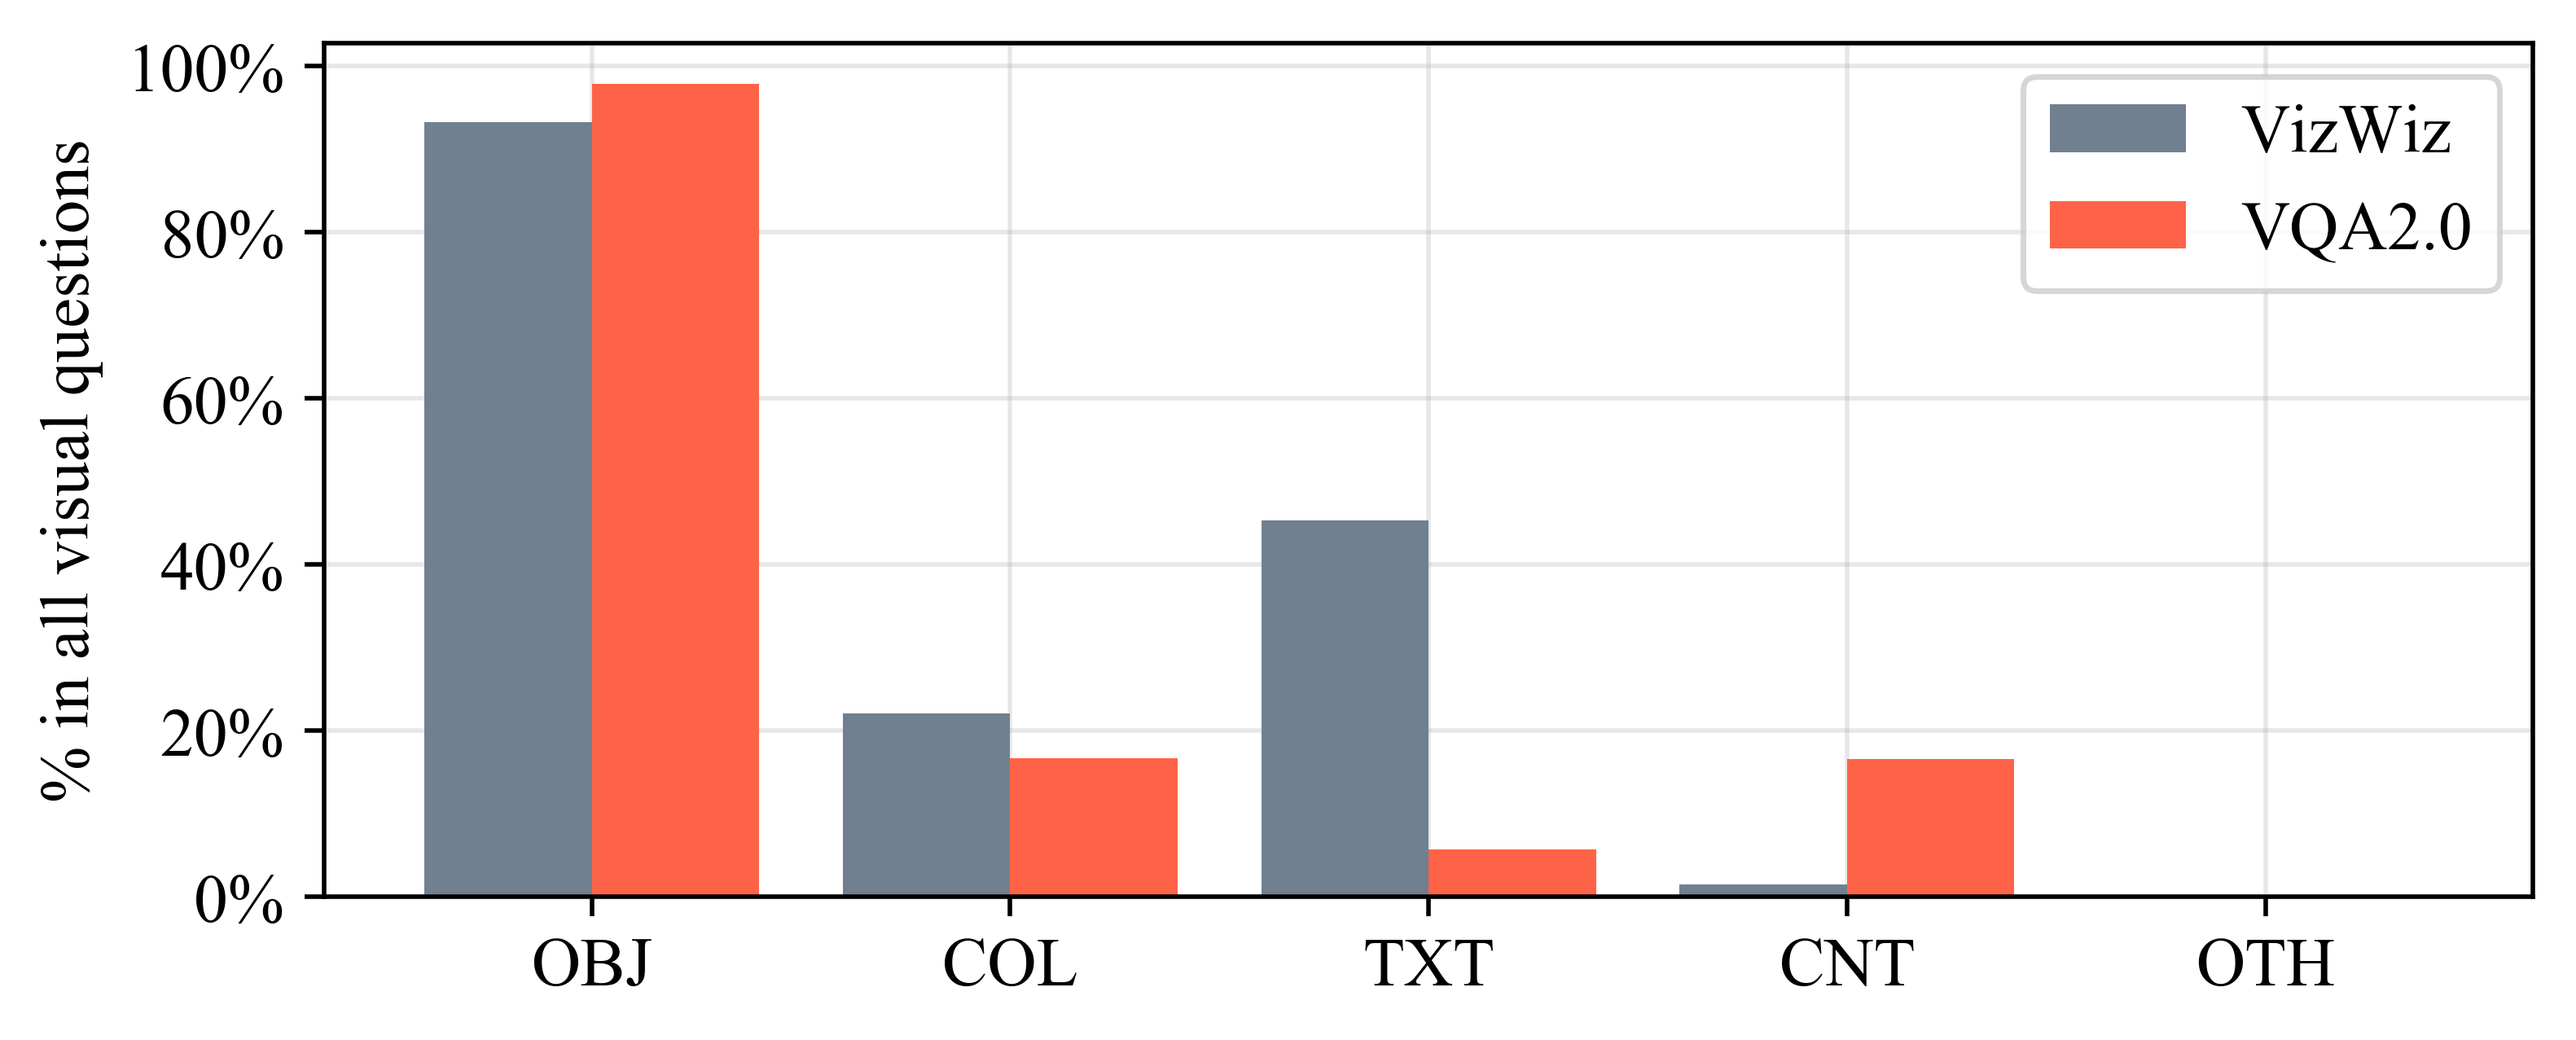

In [253]:
# one skill

fig = figure(num=None, figsize=(7, 10), dpi=500)
w = 0.4
itv = 0.2

skills = ['OBJ', 'COL', 'TXT', 'CNT', 'OTH']
_one_skill = np.arange(len(skills))
dset = vizwiz
vizwiz_data = [one_skill_nonexclusive(dset, 'OBJ'),
               one_skill_nonexclusive(dset, 'COL'), 
               one_skill_nonexclusive(dset, 'TXT'), 
               one_skill_nonexclusive(dset, 'CNT'),
               one_skill_nonexclusive(dset, 'OTH') ]
dset = vqa
vqa_data = [one_skill_nonexclusive(dset, 'OBJ'),
            one_skill_nonexclusive(dset, 'COL'), 
            one_skill_nonexclusive(dset, 'TXT'),
            one_skill_nonexclusive(dset, 'CNT'),
            one_skill_nonexclusive(dset, 'OTH') ]

one_skill_plot = fig.add_subplot(3,1,1, sharex=None, sharey=None)
one_skill_plot.grid(alpha=.3)
one_skill_plot.set_axisbelow(True)
one_skill_plot.bar(_one_skill-itv, vizwiz_data, width=w, alpha=1, label='VizWiz', color='slategray')
one_skill_plot.bar(_one_skill+itv, vqa_data, width=w, alpha=1, label='VQA2.0', color='tomato')
one_skill_plot.set_xticks(_one_skill)
one_skill_plot.set_xticklabels(skills)
#one_skill_plot.set_xlabel('Skill')
one_skill_plot.set_ylabel('% in all visual questions')

one_skill_plot_y_ticks = one_skill_plot.get_yticks()
one_skill_plot.set_yticklabels(['{:,.0%}'.format(y) for y in one_skill_plot_y_ticks])
# one_skill_plot.set_title('Distributions of skills')
one_skill_plot.legend()

# single skill
"""
single_skills = ['COL', 'TXT', 'CNT']
_single_skill = np.arange(len(single_skills))
dset = vizwiz
vizwiz_data = [0.4988161010260458, 0.49644830307813737, 0.004735595895816891]
vqa_data = [0.36666666666666664, 0.21666666666666665, 0.41666666666666663]
single_skill_plot = fig.add_subplot(3,1,2, sharex=None, sharey=None)
single_skill_plot.grid(alpha=.3)
single_skill_plot.set_axisbelow(True)
single_skill_plot.bar(_single_skill-itv, vizwiz_data, width=w, alpha=1, label='VizWiz', color='slategray')
single_skill_plot.bar(_single_skill+itv, vqa_data, width=w, alpha=1, label='VQA2.0', color='tomato')
single_skill_plot.set_xticks(_single_skill)
single_skill_plot.set_xticklabels(single_skills)
single_skill_plot_y_ticks = single_skill_plot.get_yticks()
single_skill_plot.set_yticklabels(['{:,.0%}'.format(y) for y in single_skill_plot_y_ticks])
single_skill_plot.legend()
#single_skill_plot.set_xlabel('Skill')
single_skill_plot.set_ylabel('% in single-skill visual questions')

# two skills
two_skill_combinations = ['OBJ & COL', 
                          'OBJ & TXT', 'OBJ & CNT', 
                          'COL & TXT', 'COL & CNT', 'TXT & CNT']
_two_skill = np.arange(len(two_skill_combinations))
dset = vizwiz
vizwiz_data = [two_skill_nonexclusive(dset, 'OBJ', 'TXT'),
               two_skill_nonexclusive(dset, 'OBJ', 'COL'), 
               two_skill_nonexclusive(dset, 'OBJ', 'CNT'),
               two_skill_nonexclusive(dset, 'COL', 'TXT'), 
               two_skill_nonexclusive(dset, 'TXT', 'CNT'),
               two_skill_nonexclusive(dset, 'COL', 'CNT')]
dset = vqa
vqa_data = [two_skill_nonexclusive(dset, 'OBJ', 'TXT'),
            two_skill_nonexclusive(dset, 'OBJ', 'COL'), 
            two_skill_nonexclusive(dset, 'OBJ', 'CNT'),
            two_skill_nonexclusive(dset, 'COL', 'TXT'), 
            two_skill_nonexclusive(dset, 'TXT', 'CNT'),
            two_skill_nonexclusive(dset, 'COL', 'CNT'),
            ]
two_skill_plot = fig.add_subplot(3,1,2, sharex=None, sharey=None)
two_skill_plot.grid(alpha=.3)
two_skill_plot.set_axisbelow(True)
two_skill_plot.bar(_two_skill-itv, vizwiz_data, width=w, alpha=1, label='VizWiz', color='slategray')
two_skill_plot.bar(_two_skill+itv, vqa_data, width=w, alpha=1, label='VQA2.0', color='tomato')
two_skill_plot.set_xticklabels(two_skill_combinations)
two_skill_plot.set_xticks(_two_skill)
two_skill_plot_y_ticks = two_skill_plot.get_yticks()
two_skill_plot.set_yticklabels(['{:,.0%}'.format(y) for y in two_skill_plot_y_ticks])
# two_skill_plot.set_title('Combinations of skills')
two_skill_plot.legend()
#two_skill_plot.set_xlabel('Skill')
two_skill_plot.tick_params(axis='x', labelsize=10)
two_skill_plot.set_ylabel('% in all visual questions')
"""
plt.subplots_adjust(hspace=.3)
plt.show()

In [238]:
one_skill(vizwiz, 'COL')

COL: 0.028435166021776297


0.028435166021776297

In [242]:
len(col) / len(vizwiz)

0.028435166021776297

In [233]:
# approximately $5.7\%$ of VizWiz and $1.2\%$ of VQA required only one skill.
dset = vizwiz
vizwiz_single_skill = [one_skill(dset, 'COL'), 
               one_skill(dset, 'TXT'), one_skill(dset, 'CNT'),
               one_skill(dset, 'OTH') ]
print(np.sum(np.array(vizwiz_single_skill)))
dset = vqa
vqa_single_skill = [one_skill(dset, 'COL'), 
               one_skill(dset, 'TXT'), one_skill(dset, 'CNT'),
               one_skill(dset, 'OTH') ]
print(np.sum(np.array(vqa_single_skill)))

COL: 0.028435166021776297
TXT: 0.02830018896787546
CNT: 0.0002699541078016737
OTH: 0.0
0.05700530909745343
COL: 0.004370282081843465
TXT: 0.002582439411998411
CNT: 0.004966229638458482
OTH: 0.0
0.011918951132300359


In [80]:
# in single skill questions
dset = vizwiz
print('vizwiz, color in single skill questions: ', 0.028435166021776297 /  0.05700530909745343)
print('text in single skill questions:', 0.02830018896787546 / 0.05700530909745343)
print('counting in single skill questions:', 0.0002699541078016737 / 0.05700530909745343)

vizwiz, color in single skill questions:  0.4988161010260458
text in single skill questions: 0.49644830307813737
counting in single skill questions: 0.004735595895816891


In [81]:
dset = vqa 
print('vqa, color in single skill questions: ', 0.004370282081843465 / 0.011918951132300359)
print('text in single skill questions:', 0.002582439411998411 / 0.011918951132300359)
print('counting in single skill questions:', 0.004966229638458482 / 0.011918951132300359)

vqa, color in single skill questions:  0.36666666666666664
text in single skill questions: 0.21666666666666665
counting in single skill questions: 0.41666666666666663


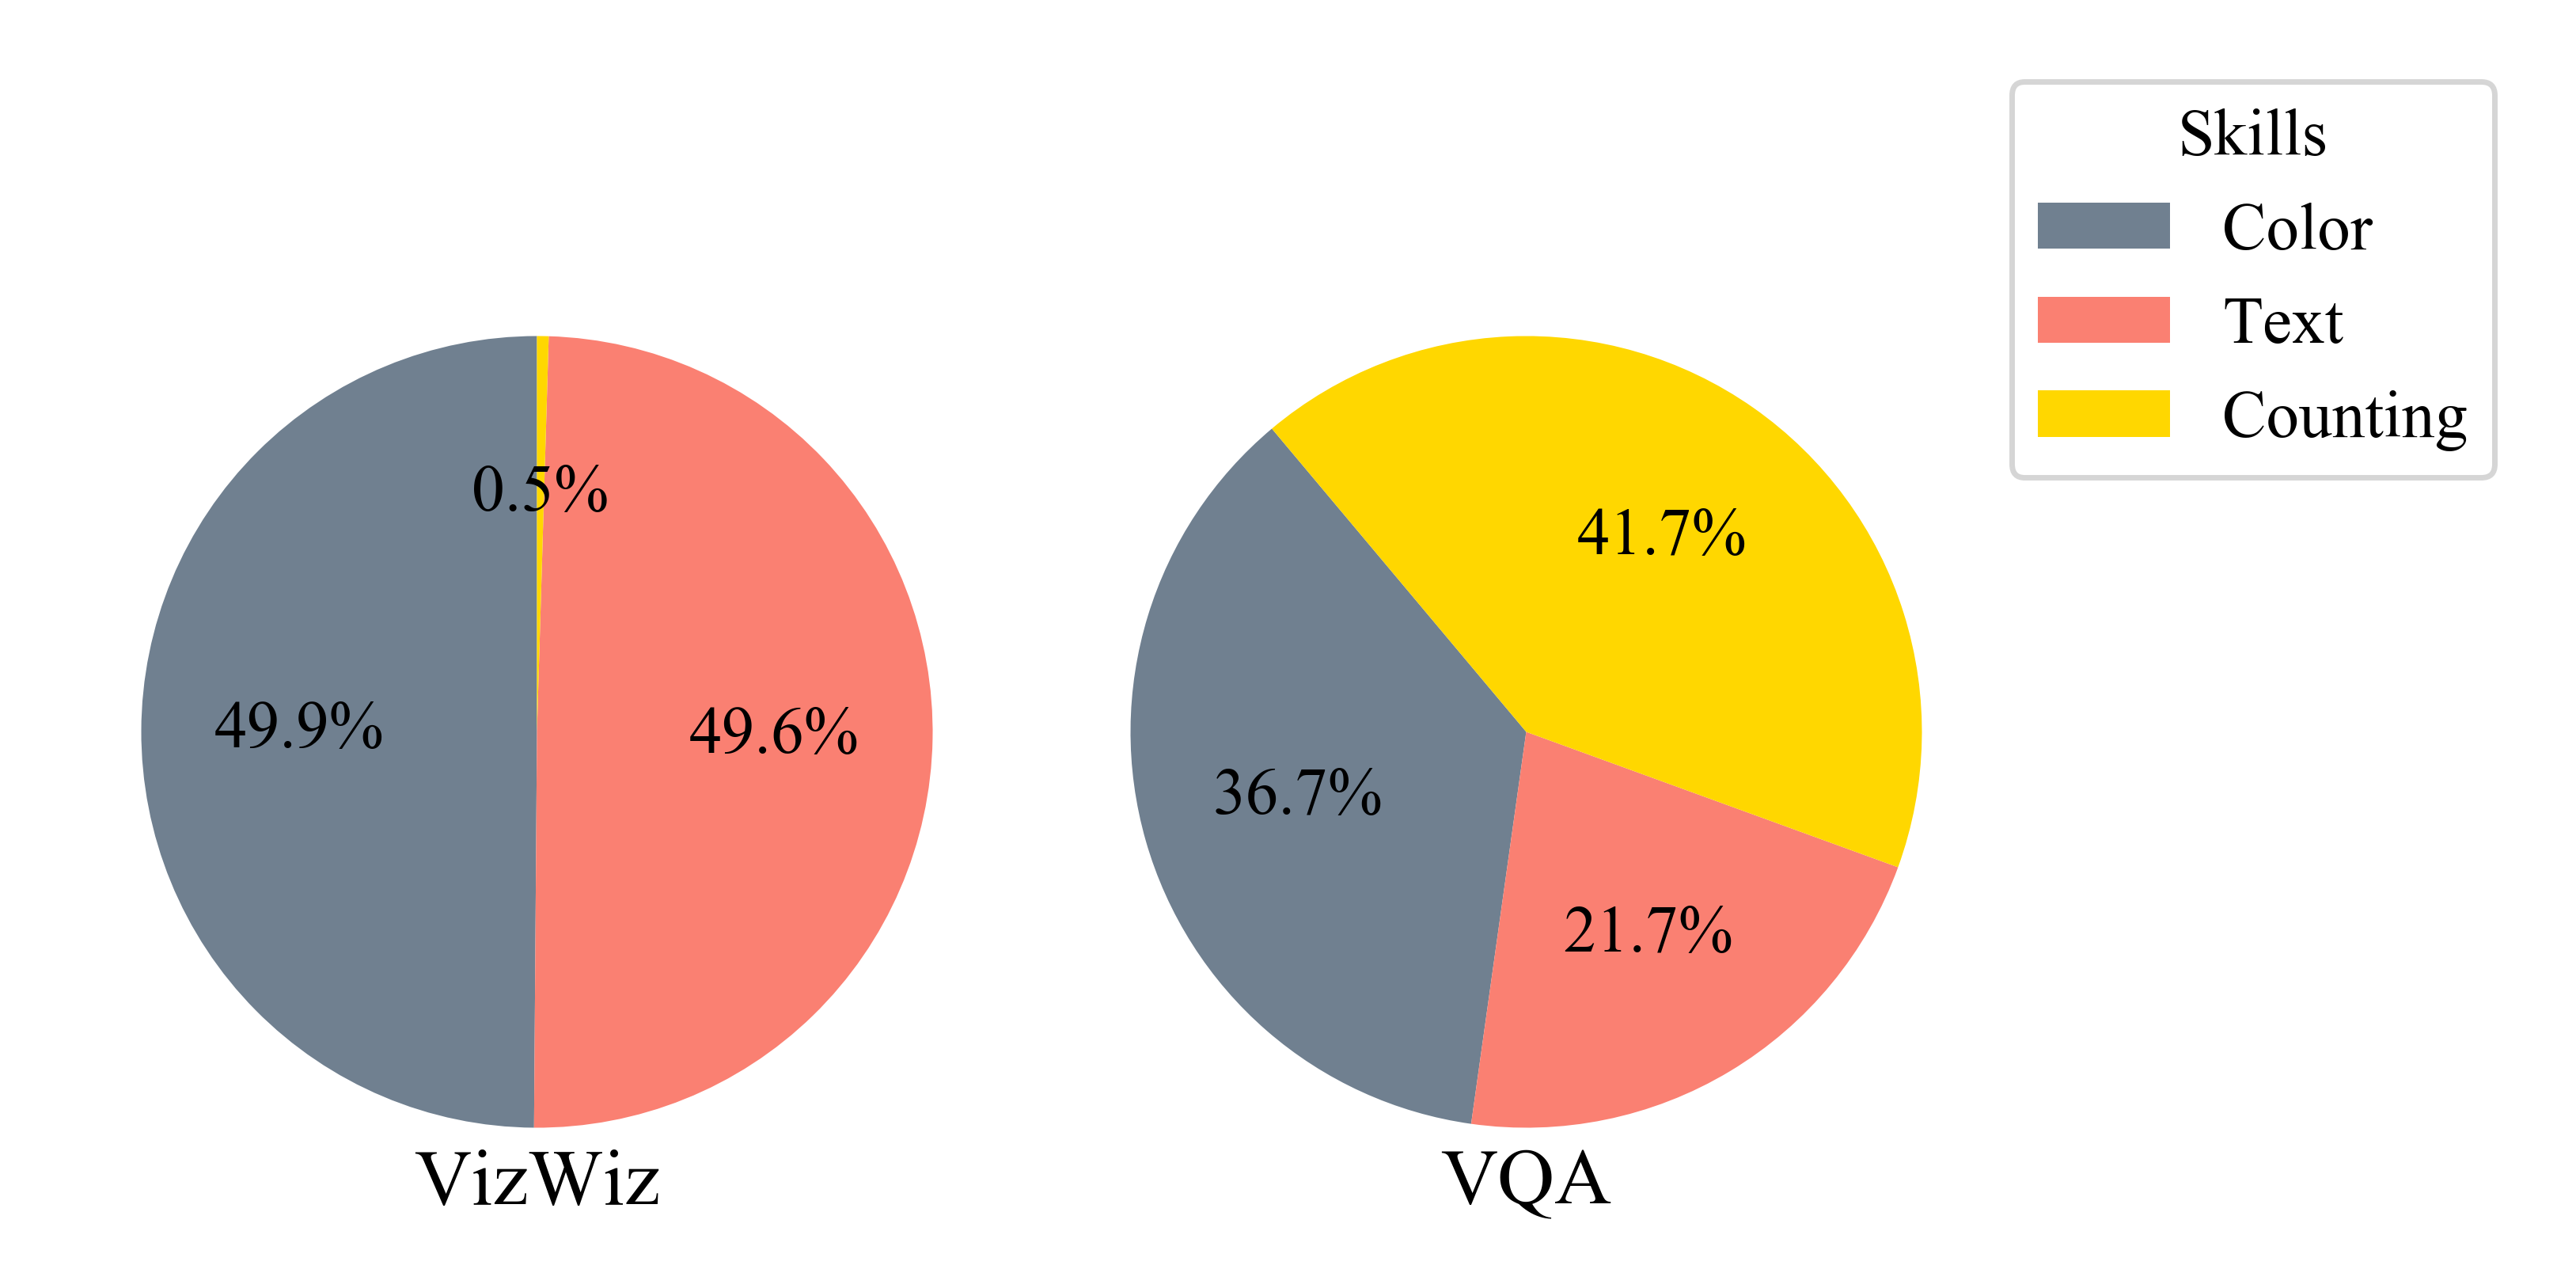

In [295]:
# pie charts of single skill distribution

labels = 'Color', 'Text', 'Counting'
vizwiz_sizes = [49.8816, 49.6448, 0.4736]
vqa_sizes = [36.6667, 21.6667, 41.6667]

fig = plt.figure(num=None, figsize=(5,5), dpi=500)

ax1 = fig.add_axes([0, 0, .5, .5], aspect=1)
ax1.pie(vizwiz_sizes, autopct='%1.1f%%', radius=1.,
        shadow=False, startangle=90, colors=['slategray', 'salmon', 'gold'])
ax2 = fig.add_axes([.5, .0, .5, .5], aspect=1)
ax2.pie(vqa_sizes, autopct='%1.1f%%', radius=1.,
        shadow=False, startangle=130, colors=['slategray', 'salmon', 'gold'])
ax1.set_title('VizWiz', y=-0.01)
ax2.set_title('VQA', y=-0.01)

fig.legend(wedges1, [x.split()[-1] for x in labels],
          title="Skills",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

# plt.subplots_adjust(wspace=.9)
plt.show()

In [198]:
# ratio of multi skill questions 
dset = vizwiz
vizwiz_data = [two_skill_nonexclusive(dset, 'COL', 'TXT'),
            two_skill_nonexclusive(dset, 'TXT', 'CNT'),
            two_skill_nonexclusive(dset, 'COL', 'CNT'),
            ]
dset = vqa
vqa_data = [two_skill_nonexclusive(dset, 'COL', 'TXT'),
            two_skill_nonexclusive(dset, 'TXT', 'CNT'),
            two_skill_nonexclusive(dset, 'COL', 'CNT'),
            ]

COL & TXT: 0.01120309547376946
TXT & CNT: 0.008548546747053002
COL & CNT: 0.0004499235130027895
COL & TXT: 0.0013905442987683751
TXT & CNT: 0.0077473182359952325
COL & CNT: 0.009137862534763607


In [199]:
vizwiz.head(1)

,Unnamed: 0,QID,TXT,OBJ,COL,CNT,OTH,SRC_DATASET,ANS_TYP,IMG,...,ANS4,ANS5,ANS6,ANS7,ANS8,ANS9,ANS10,NUM_UNIQUE_ANS,NUM_MOST_COMMON_ANS,split
0,10756,VizWiz_train_000000000000.jpg,4,3,0,0,0,VizWiz,other,VizWiz_train_000000000000.jpg,...,basil,basil leaves,basil leaves,basil leaves,basil leaves,basil leaves,basil,2,7,train


In [245]:
vizwiz = vizwiz[['TXT', 'OBJ', 'COL', 'CNT', 'OTH']]
vqa = vqa[['TXT', 'OBJ', 'COL', 'CNT', 'OTH']]

vizwiz_txt = vizwiz.loc[(vizwiz['TXT'] >= 3) & (vizwiz['COL'] < 3) & (vizwiz['CNT'] < 3)]
vizwiz_col = vizwiz.loc[(vizwiz['COL'] >= 3) & (vizwiz['TXT'] < 3) & (vizwiz['CNT'] < 3)]
vizwiz_cnt = vizwiz.loc[(vizwiz['CNT'] >= 3) & (vizwiz['TXT'] < 3) & (vizwiz['COL'] < 3)]

len(vizwiz_txt)/len(vizwiz) + len(vizwiz_col)/len(vizwiz) + len(vizwiz_cnt)/len(vizwiz)

0.6486997210474219

In [247]:
vqa_txt = vqa.loc[(vqa['TXT'] >= 3) & (vqa['COL'] < 3) & (vqa['CNT'] < 3)]
vqa_col = vqa.loc[(vqa['COL'] >= 3) & (vqa['TXT'] < 3) & (vqa['CNT'] < 3)]
vqa_cnt = vqa.loc[(vqa['CNT'] >= 3) & (vqa['COL'] < 3) & (vqa['TXT'] < 3)]

len(vqa_txt)/len(vqa) + len(vqa_col)/len(vqa) + len(vqa_cnt)/len(vqa)

0.35299960270162895

In [7]:
vizwiz_txt_col = vizwiz.loc[(vizwiz['TXT'] >= 3) & (vizwiz['COL'] >= 3) & (vizwiz['CNT'] < 3)]
vizwiz_col_cnt = vizwiz.loc[(vizwiz['COL'] >= 3) & (vizwiz['CNT'] >= 3) & (vizwiz['TXT'] < 3)]
vizwiz_txt_cnt = vizwiz.loc[(vizwiz['TXT'] >= 3) & (vizwiz['CNT'] >= 3) & (vizwiz['COL'] < 3)]

vqa_txt_col = vqa.loc[(vqa['TXT'] >= 3) & (vqa['COL'] >= 3) & (vqa['CNT'] < 3)]
vqa_col_cnt = vqa.loc[(vqa['COL'] >= 3) & (vqa['CNT'] >= 3) & (vqa['TXT'] < 3)]
vqa_txt_cnt = vqa.loc[(vqa['TXT'] >= 3) & (vqa['CNT'] >= 3) & (vqa['COL'] < 3)]

In [19]:
def questions_with_two_skills(df):
    return df.loc[((df['COL'] >= 3) & (df['TXT'] >= 3) & (df['CNT'] < 3)) |
          ((df['CNT'] >= 3) & (df['TXT'] >= 3) & (df['COL'] < 3)) |
           ((df['CNT'] >= 3) & (df['COL'] >= 3) & (df['TXT'] < 3))
          ]

In [20]:
vizwiz_two_skills = questions_with_two_skills(vizwiz)
vqa_two_skills = questions_with_two_skills(vqa)
#vizwiz_two_skills = len(vizwiz_txt_col + vizwiz_col_cnt + vizwiz_txt_cnt)
#vqa_two_skills = len(vqa_txt_col + vqa_col_cnt + vqa_txt_cnt)
len(vizwiz_txt_col) / len(vizwiz_two_skills)

0.5575620767494357

2

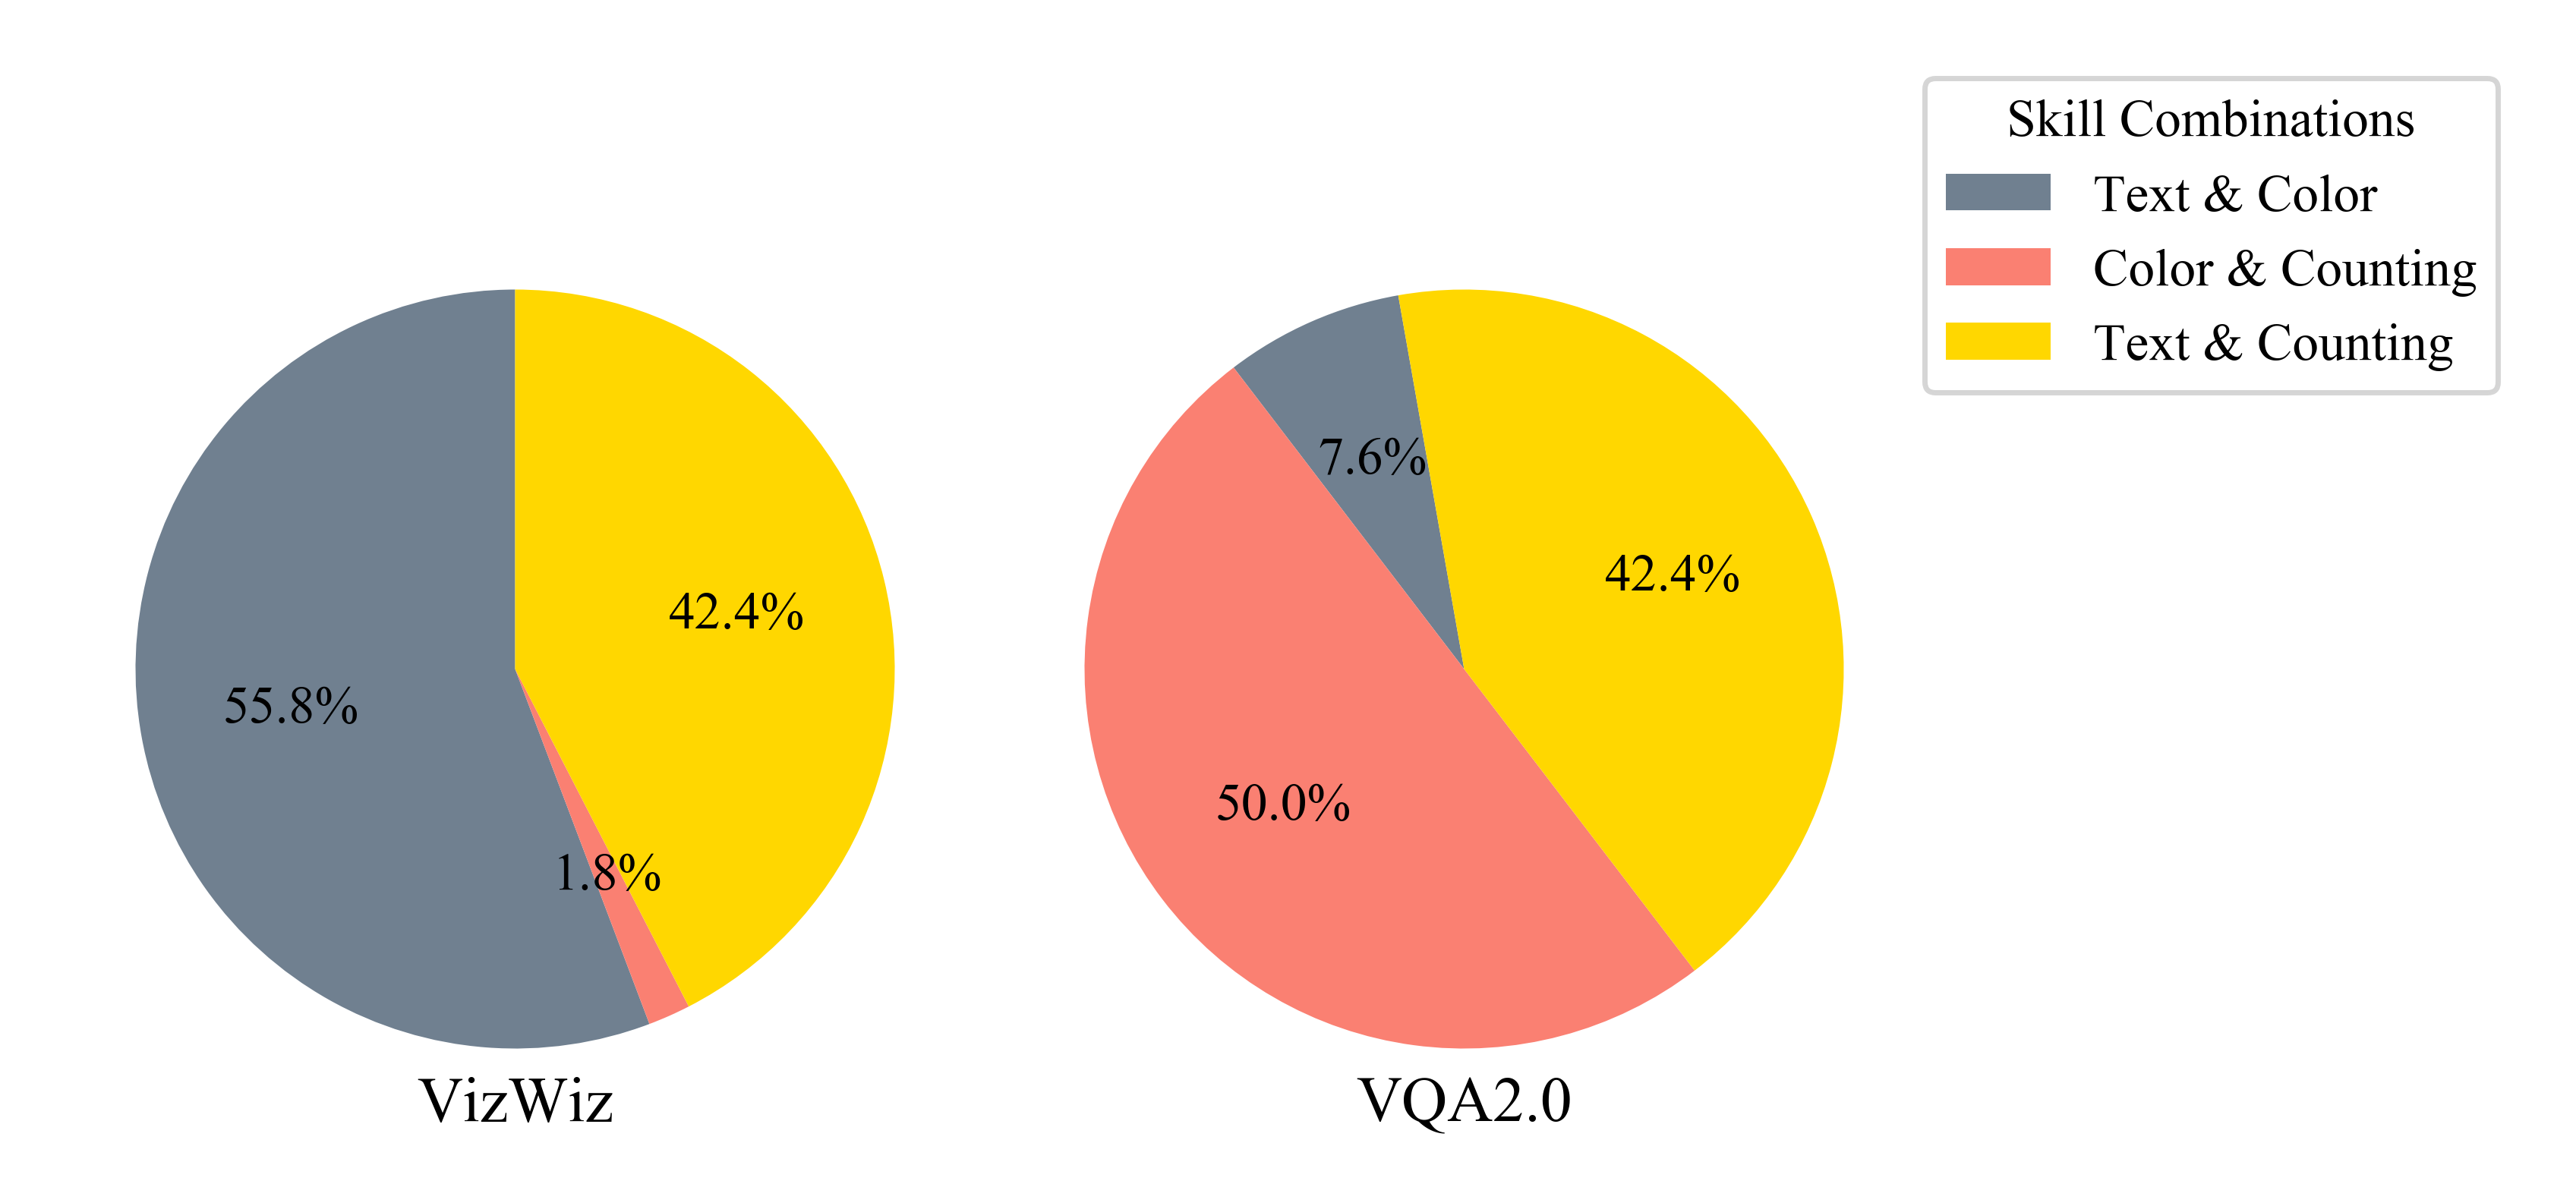

In [36]:
# pie charts of double skill distribution
fig.clear()
two_skill_labels = 'Text & Color', 'Color & Counting', 'Text & Counting'
vizwiz_sizes = [len(vizwiz_txt_col) / len(vizwiz_two_skills), 
                len(vizwiz_col_cnt) / len(vizwiz_two_skills), 
                len(vizwiz_txt_cnt) / len(vizwiz_two_skills)]
vqa_sizes = [len(vqa_txt_col) / len(vqa_two_skills), 
                len(vqa_col_cnt) / len(vqa_two_skills), 
                len(vqa_txt_cnt) / len(vqa_two_skills)]

fig = plt.figure(num=None, figsize=(5,5), dpi=500)

ax1 = fig.add_axes([0, 0, .5, .5], aspect=1)

ax1.pie(vizwiz_sizes, autopct='%1.1f%%', radius=1.,
        shadow=False, startangle=90, colors=['slategray', 'salmon', 'gold'])
ax1.set_title('VizWiz', y=-0.01)


ax2 = fig.add_axes([.5, .0, .5, .5], aspect=1)
ax2.pie(vqa_sizes, autopct='%1.1f%%', radius=1.,
        shadow=False, startangle=100, colors=['slategray', 'salmon', 'gold'])

ax2.set_title('VQA2.0',y=-0.01)

fig.legend(# labels=[x.split()[-1] for x in two_skill_labels],
            labels=two_skill_labels,
            title="Skill Combinations",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.subplots_adjust(wspace=2)

plt.show()

In [298]:
vqa.head(1)

,TXT,OBJ,COL,CNT,OTH
0,0,5,2,0,2


### Contractions / keyword correlation with skills

In [7]:
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"cant": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"didnt": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oclock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"theirs": "their has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"whats": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"yall": "you all",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [4]:
c_vizwiz = vizwiz.copy()
c_vizwiz['question'] = ""
last_idx = len(c_vizwiz.columns) - 1

for i, row in c_vizwiz.iterrows():
    question = row['QSN'].lower()
    exp = question.split()[0]
    if exp in contractions:
        vizwiz.iloc[i,-1] = question.replace(exp, contractions[exp])

#### correlations between keywords and skill labels

In [37]:
def color_flag(row):
    if row['COL'] >= 3:
        return 1.
    else:
        return 0.
def color_kw(row):
    if 'color' in row['QSN'].lower():
        return 1.
    else:
        return 0.

keyword_vizwiz = vizwiz.copy()
keyword_vizwiz['color'] = keyword_vizwiz.apply(lambda row: color_flag(row), axis=1)
keyword_vizwiz['kw'] = keyword_vizwiz.apply(lambda row: color_kw(row), axis=1)

keyword_vqa = vqa.copy()
keyword_vqa['color'] = vqa.apply(lambda row: color_flag(row), axis=1)
keyword_vqa['kw'] = vqa.apply(lambda row: color_kw(row), axis=1)

In [27]:
keyword_vizwiz['color'].corr(keyword_vizwiz['kw'])

0.7556347884001726

In [39]:
keyword_vqa['color'].corr(keyword_vqa['kw'])

0.592911610457613